# Group 2: Dekker, Hauser, Tassone, Vogel

## Introductory part
e.g. loading packages, reading data, EDA

In [1]:
##### packages
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


import math
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import pingouin as pg
from pingouin import multivariate_normality
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from missingpy import MissForest
from impyute.imputation.cs import mice

C:\Users\Corinne Vogel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
##### reading the data
df14 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2014_Financial_Data.csv')
df15 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2015_Financial_Data.csv')
df16 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2016_Financial_Data.csv')
df17 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2017_Financial_Data.csv')
df18 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2018_Financial_Data.csv')

df_sp500 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/sp-500-historical-annual-returns-modified.csv')



In [3]:
##### df manipulation

#add column with year
df14['year'] = 2014
df15['year'] = 2015
df16['year'] = 2016
df17['year'] = 2017
df18['year'] = 2018

#add column for recommendation
df14['recommendation'] = 0
df15['recommendation'] = 0
df16['recommendation'] = 0
df17['recommendation'] = 0
df18['recommendation'] = 0

#rename 'Price Var' col
df14.rename(columns={"2015 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df15.rename(columns={"2016 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df16.rename(columns={"2017 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df17.rename(columns={"2018 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df18.rename(columns={"2019 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)

# df14.index = df14.Stock
# df15.index = df15.Stock
# df16.index = df16.Stock
# df17.index = df17.Stock
# df18.index = df18.Stock


#create a list with all raw data
df_all = pd.concat([df14, df15, df16, df17, df18], ignore_index=True)

In [4]:
##### Classifiaction (1: buy, 0: hold, -1: sell)
sp500_14 = df_sp500.iloc[0,1]
sp500_15 = df_sp500.iloc[1,1]
sp500_16 = df_sp500.iloc[2,1]
sp500_17 = df_sp500.iloc[3,1]
sp500_18 = df_sp500.iloc[4,1]

conditions_y = [(df_all['year']==2014),
                (df_all['year']==2015),
                (df_all['year']==2016),
                (df_all['year']==2017),
                (df_all['year']==2018)]

values_y = [sp500_14, sp500_15, sp500_16, sp500_17, sp500_18]

#insert the according sp500 return to the corresponding year
df_all['sp500'] = np.select(conditions_y, values_y)

# calculate recommendation value
lower_bound = -2.5
upper_bound = 2.5

conditions_r = [((df_all['PRICE_VAR'] - df_all['sp500']) > upper_bound),
                ((df_all['PRICE_VAR'] - df_all['sp500']) < lower_bound),
                ((df_all['PRICE_VAR'] - df_all['sp500']) <= upper_bound) & ((df_all['PRICE_VAR'] - df_all['sp500']) >= lower_bound)]
values_r = ['1', '-1', '0']

#assign 1, -1, 0 depending on the surplus yield of a stock
df_all['recommendation'] = np.select(conditions_r, values_r)
df_all['recommendation'] = df_all['recommendation'].astype('category')
df_all['recommendation'].value_counts()
    #minor EDA that counts the frequency of the different categories
    


# drop column sp500
df_all = df_all.drop(df_all.columns[-1], axis=1)
df_all.head()


-1    11278
1      9738
0      1061
Name: recommendation, dtype: int64

,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE_VAR,Class,year,recommendation
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014,-1
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014,-1
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,2014,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014,-1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014,0


In [5]:
##### some minor EDA

df14.columns
df14.info() #we have mostly floats, but also 3 integer variables and 2 object variables (possible to use e.g. 'One-Hot-Encoding' or 'LabelEncoding' for object variable)
df14['Class']
df14.describe()

#check which are the integer and object variables
df14.select_dtypes(include = ['integer']) #class, year & recommendation
df14.select_dtypes(include = ['object']) #sector

#having a look at the other years
df15.info()
df16.info()
df17.info()
df18.info()

#dimensions for each data set
year = 14
for el in [df14, df15, df16, df17, df18]:
    print(year, el.shape)
    year += 1

Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Asset Growth', 'Book Value per Share Growth', 'Debt Growth',
       'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector', 'PRICE_VAR',
       'Class', 'year', 'recommendation'],
      dtype='object', length=227)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 6.6+ MB


0       0
1       0
2       1
3       1
4       1
       ..
3803    1
3804    0
3805    0
3806    1
3807    0
Name: Class, Length: 3808, dtype: int64

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,PRICE_VAR,Class,year,recommendation
count,3.764000e+03,3572.000000,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.745000e+03,3.728000e+03,...,3518.000000,3518.000000,3439.000000,3506.000000,3561.000000,3565.000000,3.808000e+03,3808.000000,3808.0,3808.0
mean,5.879050e+09,12.954244,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,1.438144e+09,6.748248e+08,1.002018e+08,5.725866e+08,...,0.164692,2.279999,0.813931,1.361780,0.596529,0.382284,9.751560e+02,0.429097,2014.0,0.0
std,3.901741e+10,705.605473,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.305171e+09,3.786291e+09,6.991091e+08,2.793740e+09,...,2.195115,92.428920,25.630214,18.734301,25.894049,4.696975,4.098461e+04,0.495012,0.0,0.0
min,-6.276160e+08,-1.773200,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-1.088448e+09,-6.786000e+09,-2.250000e+08,-8.878000e+09,...,-1.000000,-0.979600,-230.000000,-1.051000,-1.043700,-1.000000,-1.003972e+02,0.000000,2014.0,0.0
25%,5.788880e+07,-0.002350,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,...,0.000000,-0.015400,-0.084550,-0.048200,0.000000,-0.003900,-2.857143e+01,0.000000,2014.0,0.0
50%,4.349010e+08,0.061850,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386610e+08,4.104400e+07,2.563000e+06,2.842700e+07,...,0.000000,0.062200,0.037100,0.000000,0.000000,0.068800,-5.281842e+00,0.000000,2014.0,0.0
75%,2.393625e+09,0.188875,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,...,0.063850,0.217100,0.141900,0.210300,0.004700,0.220500,1.331484e+01,1.000000,2014.0,0.0
max,1.824698e+12,42138.663900,1.537249e+12,4.621600e+11,1.153700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,76.625000,5468.426400,1360.125000,729.576600,1542.611000,225.690000,2.418601e+06,1.000000,2014.0,0.0


,Class,year,recommendation
0,0,2014,0
1,0,2014,0
2,1,2014,0
3,1,2014,0
4,1,2014,0
...,...,...,...
3803,1,2014,0
3804,0,2014,0
3805,0,2014,0
3806,1,2014,0


,Stock,Sector
0,PG,Consumer Defensive
1,VIPS,Consumer Defensive
2,KR,Consumer Defensive
3,RAD,Consumer Defensive
4,GIS,Consumer Defensive
...,...,...
3803,TSRI,Technology
3804,TZOO,Technology
3805,USATP,Technology
3806,WSTG,Technology


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 7.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 8.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 7.6+ MB
14 (3808, 227)
15 (4120, 227)
16 (4797, 227)
17 (4960, 227)
18 (4392, 227)


## Feature Engineering
### Momentum Factor
As Dacheng showed in his paper "Empirical Machine Learning via Asset Pricing", a very strong covariate is the momentum factor. This factor simply represents the past performance of a given stock. In our case we could take the performance of the current year to predict the performance of the next year. It is possible to create even more covariates like change in momentum (chmom) but we will not go further into those.

Problems: Data for 2014 is not available. The amount of stocks in the data set changes every year.
We will have some missing values that we can again impute with a KNN imputer.

In [6]:
#we create numpy arrays that we will fill with the data and then add to the full data set
momentum_2014 = np.empty(shape = df14.shape[0])
momentum_2015 = np.empty(shape = df15.shape[0])
momentum_2016 = np.empty(shape = df16.shape[0])
momentum_2017 = np.empty(shape = df17.shape[0])
momentum_2018 = np.empty(shape = df18.shape[0])

momentum_2014[:] = np.NAN
momentum_2015[:] = np.NAN
momentum_2016[:] = np.NAN
momentum_2017[:] = np.NAN
momentum_2018[:] = np.NAN


#we take the available data and fill them into the momentum arrays
#2015
i = 0
for stock in df15.index:
    if stock in df14.index:
        momentum_2015[i] = df14['PRICE_VAR'][stock]
    i+=1
    
#2016
i = 0
for stock in df16.index:
    if stock in df15.index:
        momentum_2016[i] = df15['PRICE_VAR'][stock]
    i+=1

#2017
i = 0
for stock in df17.index:
    if stock in df16.index:
        momentum_2017[i] = df16['PRICE_VAR'][stock]
    i+=1

#2018
i = 0
for stock in df18.index:
    if stock in df17.index:
        momentum_2018[i] = df17['PRICE_VAR'][stock]
    i+=1

In [7]:
#count the missing values
np.count_nonzero(np.isnan(momentum_2014))
np.count_nonzero(np.isnan(momentum_2015))
np.count_nonzero(np.isnan(momentum_2016))
np.count_nonzero(np.isnan(momentum_2017))
np.count_nonzero(np.isnan(momentum_2018))

3808

312

677

163

0

In [8]:
#####add the momentum factor to the full data set
momentum_2014 = pd.Series(momentum_2014)
momentum_2015 = pd.Series(momentum_2015)
momentum_2016 = pd.Series(momentum_2016)
momentum_2017 = pd.Series(momentum_2017)
momentum_2018 = pd.Series(momentum_2018)
Momentum = pd.concat([momentum_2014, momentum_2015, momentum_2016, momentum_2017, momentum_2018], ignore_index = True)

#insert the new variable
df_all.insert(loc=223, column='Momentum', value=Momentum)
df_all.tail()

# 228 columns (stock, recommendation, PriceVar, Class, Year, + 223 features)
print(df_all.columns)


,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Momentum,PRICE_VAR,Class,year,recommendation
22072,YRIV,0.0,0.0000,0.0,0.0,0.0,3755251.0,3755251.0,-3755251.0,11058486.0,...,-0.1409,-0.0152,0.0000,-0.2602,Real Estate,-35.647526,-90.962099,0,2018,-1
22073,YTEN,556000.0,-0.4110,0.0,556000.0,4759000.0,5071000.0,9830000.0,-9274000.0,0.0,...,-0.8602,0.0000,0.0352,-0.0993,Basic Materials,-41.956061,-77.922077,0,2018,-1
22074,ZKIN,54884381.0,0.2210,36593792.0,18290589.0,1652633.0,7020320.0,8672953.0,9617636.0,1239170.0,...,0.4074,-0.0968,0.2415,0.8987,Basic Materials,9.175340,-17.834400,0,2018,-1
22075,ZOM,0.0,0.0000,0.0,0.0,10317153.0,4521349.0,16648628.0,-16648628.0,0.0,...,-0.2200,0.0000,2.7499,0.1457,Industrials,12.165180,-73.520000,0,2018,-1
22076,ZYME,53019000.0,0.0243,0.0,53019000.0,56684000.0,29457000.0,86146000.0,-33127000.0,166000.0,...,0.1325,0.0000,0.3577,0.5880,Healthcare,-28.600802,209.462222,1,2018,1


Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', 'Momentum', 'PRICE_VAR', 'Class',
       'year', 'recommendation'],
      dtype='object', length=228)


### Macroeconomic factor / Inflation Interaction Term
Since macro factors like inflation are the same for every stock in a given time point they can help indicating in which direction the market will go as a whole. In order to use them as predictors for individual stocks we need to create interaction terms where we multiply some macrofactors with some other covariates.\
\
Based on Investopedia (https://www.investopedia.com/articles/investing/031413/economic-indicatiors-affect-us-stock-market.asp) we could use for example the consumer price index change (Inflation) from https://www.statista.com/statistics/244983/projected-inflation-rate-in-the-united-states/. \
We will create those factors with the imputed data because we don't want to generate more NA values.

#### Sector Dummy
we have to create dummy variables for the sectors. In total we have 11 different sectors \
with get_dummies we create a factor for every sector


In [9]:
#note: this chunk can only be executed once since we delete the Sector column at the end of this code

#define sector as string
df_all["Sector"] = df_all["Sector"].astype(str)

#drop the 'Sector' column from the dataframe and add new columns, one dummy variable for each sector
sector_dummies = pd.get_dummies(df_all["Sector"])
df_all.drop(['Sector'], axis = 1, inplace = True)
df_all[sector_dummies.columns] = sector_dummies

#### Market Cap Dummy
The size of the company is another important covariate as Dacheng stated. We can create a categorical variable for the market cap. We could create for example 3 groups standing for "small", "middle" and "large". According to Investopedia (https://www.investopedia.com/terms/s/small-cap.asp) a small cap stock has a market cap between 300 million and 2 billion USD. Large caps have a market value of above 10 billion. Therefore we could group the stocks the following way:

Market Cap < 2 Billion -> 1. Group (small cap)

Market Cap between 2 Billion and 10 Billion -> 2. Group (mid cap)

Market Cap > 10 Billion -> 3. Group (large cap)

This is a way of taking the Small minus Big factor from the Fama-French model into account.

In [10]:
#create an empty array to store the values
Market_Cap_Groups = np.zeros(shape = len(df_all["Market Cap"]))

#Assess every stock with a group
for i, j in enumerate(df_all["Market Cap"]):
    if math.isnan(j):
        Market_Cap_Groups[i] = 0
    elif j <= 2000000000:
        Market_Cap_Groups[i] = 1
    elif j >= 10000000000:
        Market_Cap_Groups[i] = 3
    else:
        Market_Cap_Groups[i] = 2


#Add the vector to the full data set
df_all["Market_Cap_Group"] = Market_Cap_Groups

#Since we have more than 2 groups we cannot use factorize(). 
#We use the function get_dummies() to create 4 (one of which is used and later dropped for na-values in market cap) dummy variables.
df_all["Market_Cap_Group"] = df_all["Market_Cap_Group"].astype(str)
cap_dummies = pd.get_dummies(df_all["Market_Cap_Group"])
df_all[["null values", "small cap", "medium cap", "big cap"]] = cap_dummies
df_all.drop(["null values"], axis=1, inplace=True)



#Now we could delete the variable Market Cap from the data set
df_all.drop(columns = ["Market_Cap_Group"], axis = 1, inplace = True)
print(df_all.columns)

#have a quick glance at the dummies
df_all[['Market Cap', 'small cap', 'medium cap', 'big cap']]


Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Energy', 'Financial Services', 'Healthcare', 'Industrials',
       'Real Estate', 'Technology', 'Utilities', 'small cap', 'medium cap',
       'big cap'],
      dtype='object', length=241)


,Market Cap,small cap,medium cap,big cap
0,2.126614e+11,0,0,1
1,6.253200e+09,0,1,0
2,1.827470e+10,0,0,1
3,6.359738e+09,0,1,0
4,3.333006e+10,0,0,1
...,...,...,...,...
22072,6.832290e+08,1,0,0
22073,8.321423e+06,1,0,0
22074,NaN,0,0,0
22075,1.165993e+08,1,0,0


## Missing Values/NAs

### Analysis
* firstly, we have a look at how many missing values we have for which variable (also adding some graphs)
* secondly, we look at variables with an unusual high NA count
* next, we implement a first imputer (KNN) and then fit a very naive classification tree to see which variables the model would choose (without any restrictions, only depth=4), bear in mind that this is done at a very basic level and the results of this should looked at rather critically (on the level of meaningfulness)
* then, we drop the variables with high NA count and which are not used in the naive decision tree

In [11]:
##### check missing values
df14.isnull().sum().sum()
df15.isnull().sum().sum()
df16.isnull().sum().sum()
df17.isnull().sum().sum()
df18.isnull().sum().sum()
df_all.isnull().sum().sum()

101103

114348

212549

226269

97298

756527

['operatingCycle', 'cashConversionCycle', 'cashFlowToDebtRatio', 'cashFlowCoverageRatios', 'shortTermCoverageRatios', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', 'priceEarningsToGrowthRatio', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Dividend per Share Growth (per Share)', 'Total non-current assets', 'Total non-current liabilities', 'Net Debt', 'Other Assets', 'priceCashFlowRatio', 'enterpriseValueMultiple', 'ebtperEBIT', 'returnOnAssets', 'returnOnCapitalEmployed', 'eBTperEBIT', 'freeCashFlowOperatingCashFlowRatio', 'Current ratio', 'ROIC', 'Return on Tangible Assets', 'Working Capital', '5Y Revenue Growth (per Share)', '5Y Operating CF Growth (per Share)', '5Y Net Income Growth (per Share)', '5Y Shareholders Equity Growth (per Share)', '5Y Dividend per Share Growth (per Share)']


36

Stock                                         0.000000
Class                                         0.000000
year                                          0.000000
recommendation                                0.000000
Basic Materials                               0.000000
                                                ...   
10Y Revenue Growth (per Share)                0.431762
10Y Shareholders Equity Growth (per Share)    0.438465
shortTermCoverageRatios                       0.486660
operatingCycle                                0.999139
cashConversionCycle                           0.999139
Length: 241, dtype: float64

<Figure size 7200x2160 with 0 Axes>

<BarContainer object of 241 artists>

Text(0, 0.5, 'percentage missing values')

([<matplotlib.axis.XTick at 0x16457dc4340>,
 [Text(1, 0, 'Stock'),
  Text(2, 0, 'Revenue'),
  Text(3, 0, 'Revenue Growth'),
  Text(4, 0, 'Cost of Revenue'),
  Text(5, 0, 'Gross Profit'),
  Text(6, 0, 'R&D Expenses'),
  Text(7, 0, 'SG&A Expense'),
  Text(8, 0, 'Operating Expenses'),
  Text(9, 0, 'Operating Income'),
  Text(10, 0, 'Interest Expense'),
  Text(11, 0, 'Earnings before Tax'),
  Text(12, 0, 'Income Tax Expense'),
  Text(13, 0, 'Net Income - Non-Controlling int'),
  Text(14, 0, 'Net Income - Discontinued ops'),
  Text(15, 0, 'Net Income'),
  Text(16, 0, 'Preferred Dividends'),
  Text(17, 0, 'Net Income Com'),
  Text(18, 0, 'EPS'),
  Text(19, 0, 'EPS Diluted'),
  Text(20, 0, 'Weighted Average Shs Out'),
  Text(21, 0, 'Weighted Average Shs Out (Dil)'),
  Text(22, 0, 'Dividend per Share'),
  Text(23, 0, 'Gross Margin'),
  Text(24, 0, 'EBITDA Margin'),
  Text(25, 0, 'EBIT Margin'),
  Text(26, 0, 'Profit Margin'),
  Text(27, 0, 'Free Cash Flow margin'),
  Text(28, 0, 'EBITDA'),
  T

<AxesSubplot:>

0.09802056438827739

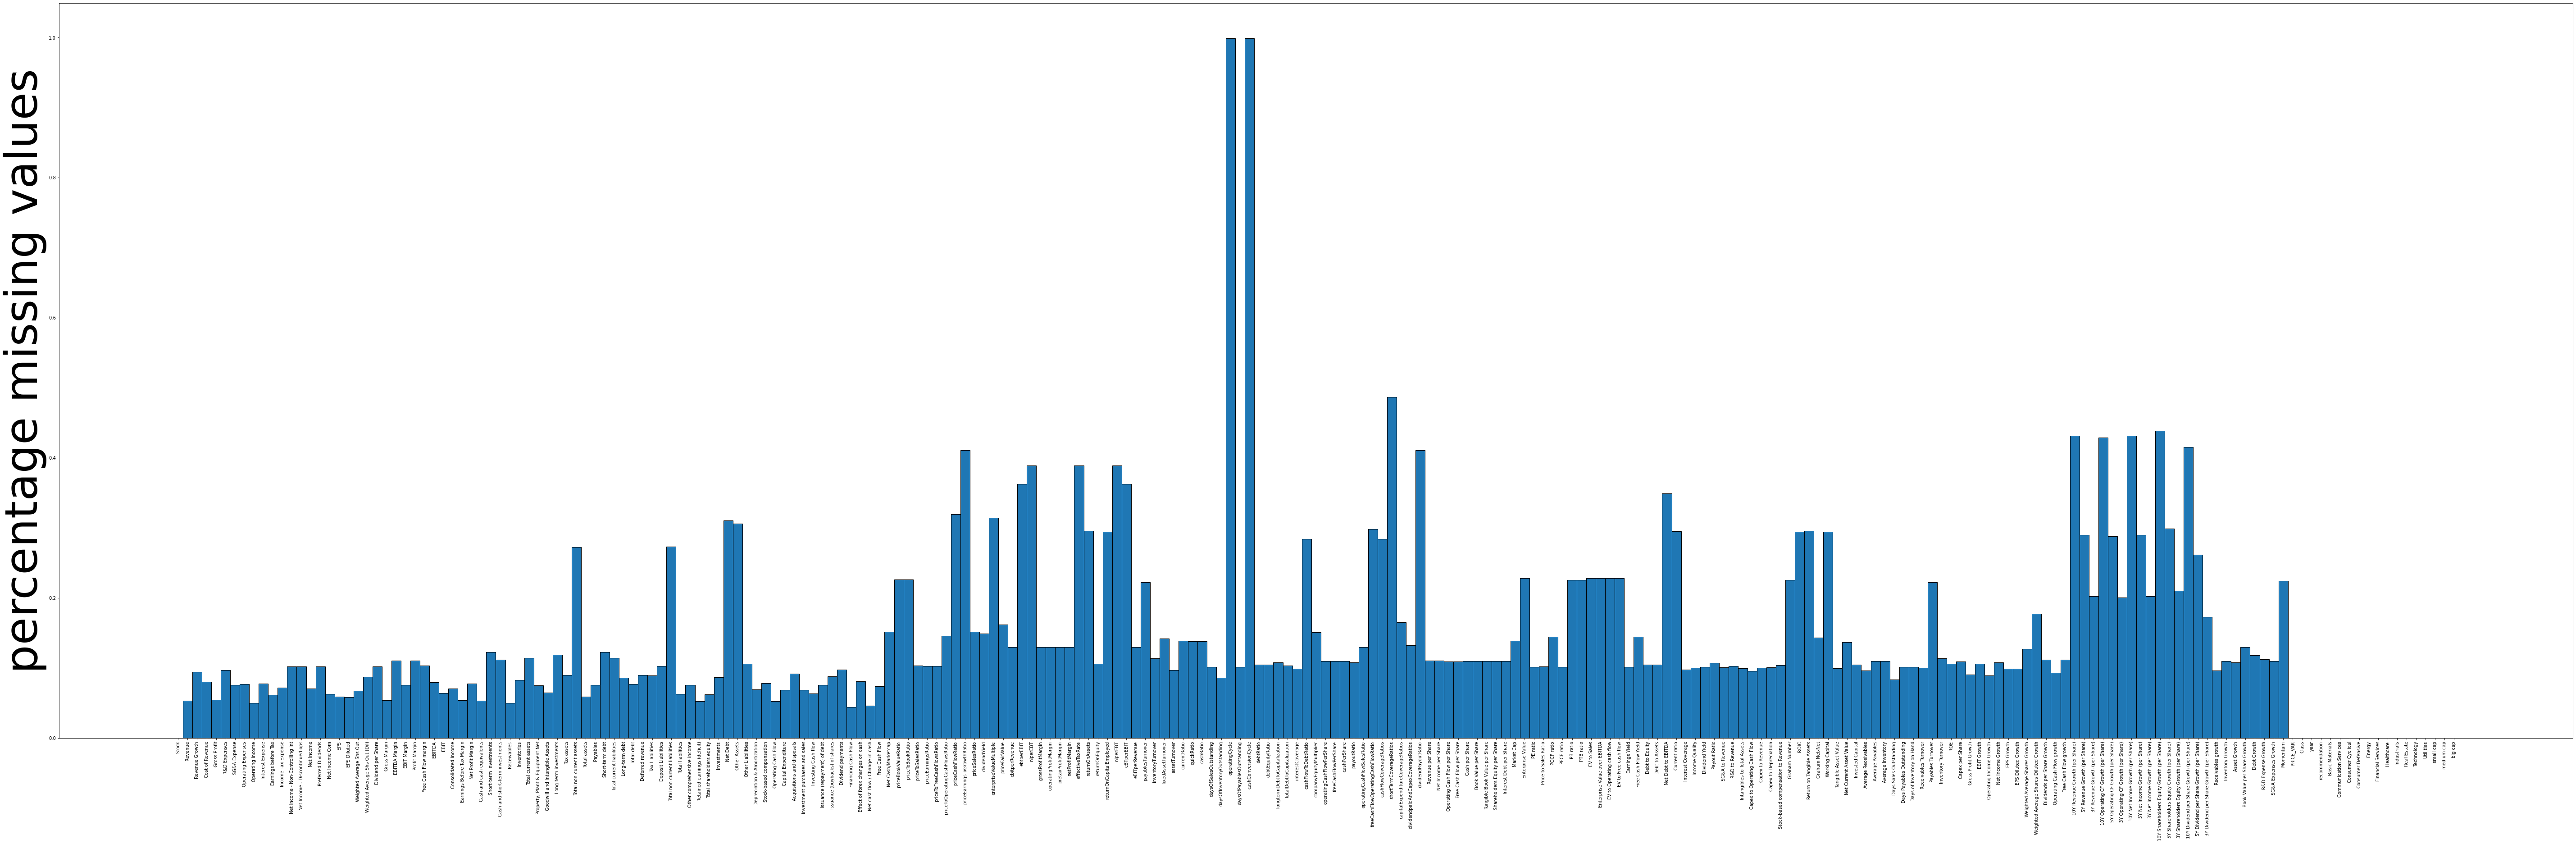

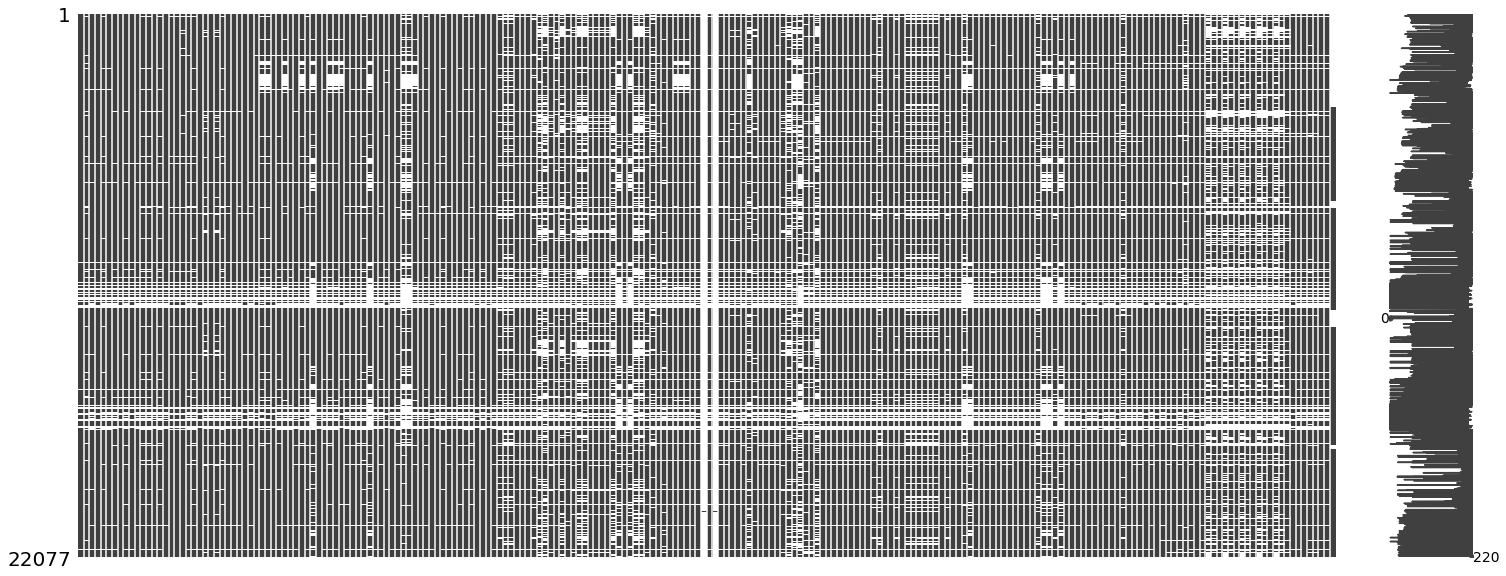

In [12]:
##### further exploration regarding NAs
#function to give back the column names and number of NAs of columns with more than a certain number of NAs
def name_gettr(data, treshold = 1500):
    res = {}
    for el in data[:1]:
        if data[el].isnull().sum() > treshold:
            res[el] = data[el].isnull().sum()
    return res

#apply function defined above
df14_outl = name_gettr(df14)
df15_outl = name_gettr(df15)
df16_outl = name_gettr(df16)
df17_outl = name_gettr(df17)
df18_outl = name_gettr(df18)


#create a list with dictionaries in order to run another function on them 
df_all_outl = [df14_outl, df15_outl, df16_outl, df17_outl, df18_outl]

#function which creates a list with all unique variables that have more than a certain number of NAs for at least one of the years of interest
def unique_high_NA (data):
    res = []
    for el in data:
        for e in el.keys():
            if not e in res:
                res.append(e)
    return(res)

#apply function and count number of variables to be retired from df
high_NA_vars = unique_high_NA(df_all_outl)
print(high_NA_vars)
len(unique_high_NA(df_all_outl)) #36 (out of 225, i.e. ~16%) variables


#graph showing percentages of values missing 
ratio_NA = df_all.isnull().sum()/len(df_all)
pd.Series.sort_values(ratio_NA)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_NA)+1), height = ratio_NA, width = 1, ec = 'black')
plt.ylabel('percentage missing values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_NA)+1), list(df_all.columns), rotation = 90)


#missing value matrix where white lines indicate missing values
missingdata = df_all.columns[df_all.isnull().any()].tolist()
msno.matrix(df_all[missingdata])
    #we clearly see that e.g. for operatingCylce and cashConversionCycle we have a huge amount of NAs 
    #this is in harmony with the barplot above where we've seen this as well
    #what is also interesting is that some firms seem to have no or almost no data
    
    

#gives out the percentage of rows with an NA count of more than 150
high_col_nas = [ x for x in df_all.isnull().sum(axis=1) if x > 150]
len(high_col_nas)/len(df_all)
#high_col_nas

0.09802056438827739

63

4980

<AxesSubplot:>

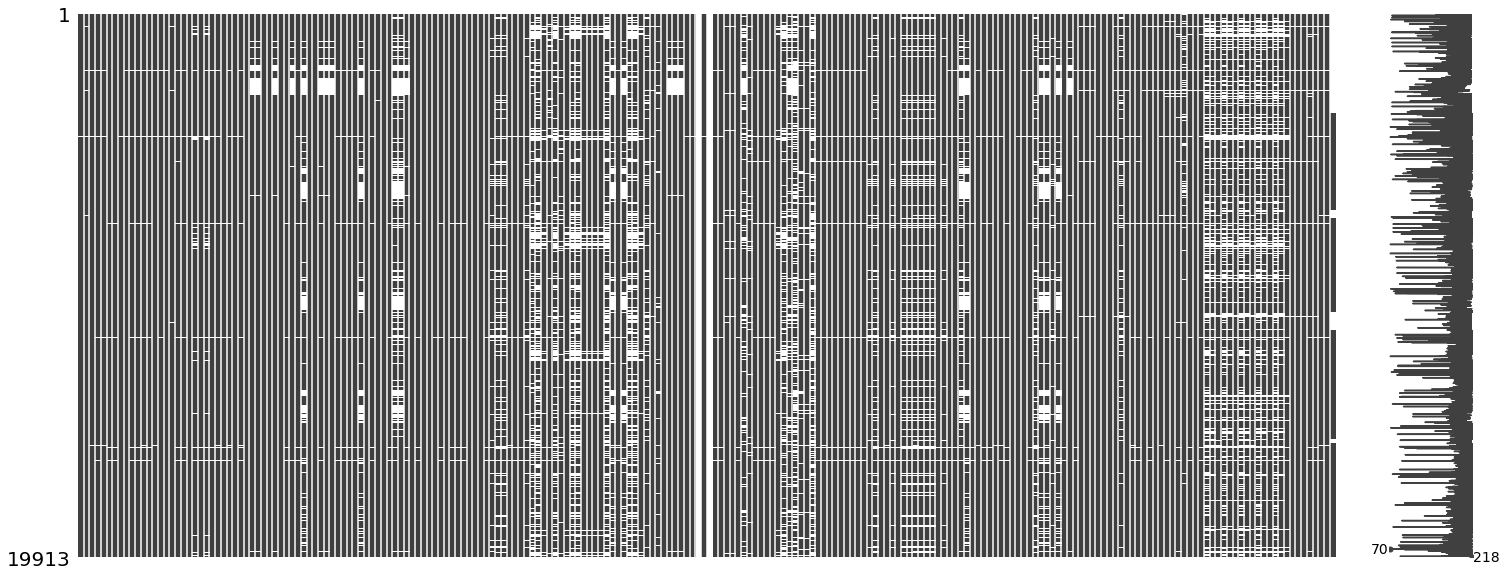

In [13]:
#gives out the percentage of rows with an NA count of more than 150
high_row_nas = [ x for x in df_all.isnull().sum(axis=1) if x > 150]
len(high_row_nas)/len(df_all)
    #we have an approximate 10% of firms with many missing values
len(set(high_row_nas))
    #63 different 'amounts' of NA values
# set(high_row_nas)


#gives out the indices of the rows with an NA count of more than 150
high_na_indices = []
for x,y in enumerate(df_all.isnull().sum(axis=1)):
    if y > 150:
        high_na_indices.append(x)
        
        
#gives out the unique names of the companies with an NA count of more than 150
# df_all["Stock"][high_na_indices]  #uncomment for names of the firms
high_na_names = set(df_all["Stock"][high_na_indices])
len(set(df_all["Stock"]))


#drop the firms with over 150 missing values from the dataframe
df_all = df_all.drop(df_all.index[high_na_indices])
df_all.index = np.arange(len(df_all))
    #re-numeration of the index
    
    
#missing value matrix where white lines indicate missing values
missingdata_after_removal = df_all.columns[df_all.isnull().any()].tolist()
msno.matrix(df_all[missingdata_after_removal])
    #we clearly see that the rows which had almost no data have been removed

In [14]:
##### implementing a KNN imputation for the whole dataset
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)


#for df_all
df_all_Stock = df_all['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df_all.drop(['Stock'], axis = 1, inplace = True) 

df_all_imputed = imputer.fit_transform(df_all)
df_all_imputed = pd.DataFrame(df_all_imputed)
df_all_imputed.columns = list(df_all)
df_all_imputed.isnull().sum().sum()

0

In [15]:
##### implementing a KNN imputation for each individual year
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)


# df14
df14_Sector = df14['Sector'] # defined above
df14_Stock = df14['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df14.drop(['Sector', 'Stock'], axis = 1, inplace = True) 

df14_imputed = imputer.fit_transform(df14)
df14_imputed = pd.DataFrame(df14_imputed)
df14_imputed.columns = list(df14)
df14_imputed.isnull().sum().sum()


# df15
df15_Sector = df15['Sector']
df15_Stock = df15['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df15.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df15_imputed = imputer.fit_transform(df15)
df15_imputed = pd.DataFrame(df15_imputed)
df15_imputed.columns = list(df15)
df15_imputed.isnull().sum().sum()


# df16
df16_Sector = df16['Sector']
df16_Stock = df16['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df16.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df16_imputed = imputer.fit_transform(df16)
df16_imputed = pd.DataFrame(df16_imputed)
df16_imputed.columns = list(df16)
df16_imputed.isnull().sum().sum()


# df17
df17_Sector = df17['Sector']
df17_Stock = df17['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df17.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df17_imputed = imputer.fit_transform(df17)
df17_imputed = pd.DataFrame(df17_imputed)
df17_imputed.columns = list(df17)
df17_imputed.isnull().sum().sum()


# df18
df18_Sector = df18['Sector']
df18_Stock = df18['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df18.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df18_imputed = imputer.fit_transform(df18)
df18_imputed = pd.DataFrame(df18_imputed)
df18_imputed.columns = list(df18)
df18_imputed.isnull().sum().sum()

0

0

0

0

0

<Figure size 3600x1440 with 0 Axes>

[Text(1395.0, 978.48, 'X[50] <= 92302224.0\ngini = 0.49\nsamples = 3808\nvalue = [2174, 1634]'),
 Text(697.5, 761.0400000000001, 'X[128] <= 2.727\ngini = 0.475\nsamples = 3333\nvalue = [2036, 1297]'),
 Text(348.75, 543.6, 'X[18] <= 7382377.0\ngini = 0.449\nsamples = 2134\nvalue = [1407, 727]'),
 Text(174.375, 326.1600000000001, 'X[40] <= 17948.5\ngini = 0.336\nsamples = 327\nvalue = [257, 70]'),
 Text(87.1875, 108.72000000000003, 'gini = 0.261\nsamples = 227\nvalue = [192, 35]'),
 Text(261.5625, 108.72000000000003, 'gini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(523.125, 326.1600000000001, 'X[81] <= 7.74\ngini = 0.463\nsamples = 1807\nvalue = [1150, 657]'),
 Text(435.9375, 108.72000000000003, 'gini = 0.382\nsamples = 494\nvalue = [367, 127]'),
 Text(610.3125, 108.72000000000003, 'gini = 0.481\nsamples = 1313\nvalue = [783, 530]'),
 Text(1046.25, 543.6, 'X[48] <= 445779008.0\ngini = 0.499\nsamples = 1199\nvalue = [629, 570]'),
 Text(871.875, 326.1600000000001, 'X[204] <= 0.003\n

|--- Deposit Liabilities <= 92302224.00
|   |--- capitalExpenditureCoverageRatios <= 2.73
|   |   |--- Weighted Average Shs Out <= 7382377.00
|   |   |   |--- Tax assets <= 17948.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- Tax assets >  17948.50
|   |   |   |   |--- class: 0.0
|   |   |--- Weighted Average Shs Out >  7382377.00
|   |   |   |--- priceCashFlowRatio <= 7.74
|   |   |   |   |--- class: 0.0
|   |   |   |--- priceCashFlowRatio >  7.74
|   |   |   |   |--- class: 0.0
|   |--- capitalExpenditureCoverageRatios >  2.73
|   |   |--- Deferred revenue <= 445779008.00
|   |   |   |--- 3Y Operating CF Growth (per Share) <= 0.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- 3Y Operating CF Growth (per Share) >  0.00
|   |   |   |   |--- class: 1.0
|   |   |--- Deferred revenue >  445779008.00
|   |   |   |--- Capital Expenditure <= -205000000.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- Capital Expenditure >  -205000000.00
|   |   |   |   |--- class: 1.0
|--- Deposit

array([ 50, 128,  18,  40,  81,  48, 204,  63,   3,  59,  12,  61, 141,
        78, 137], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


priceCashFlowRatio    1053
dtype: int64

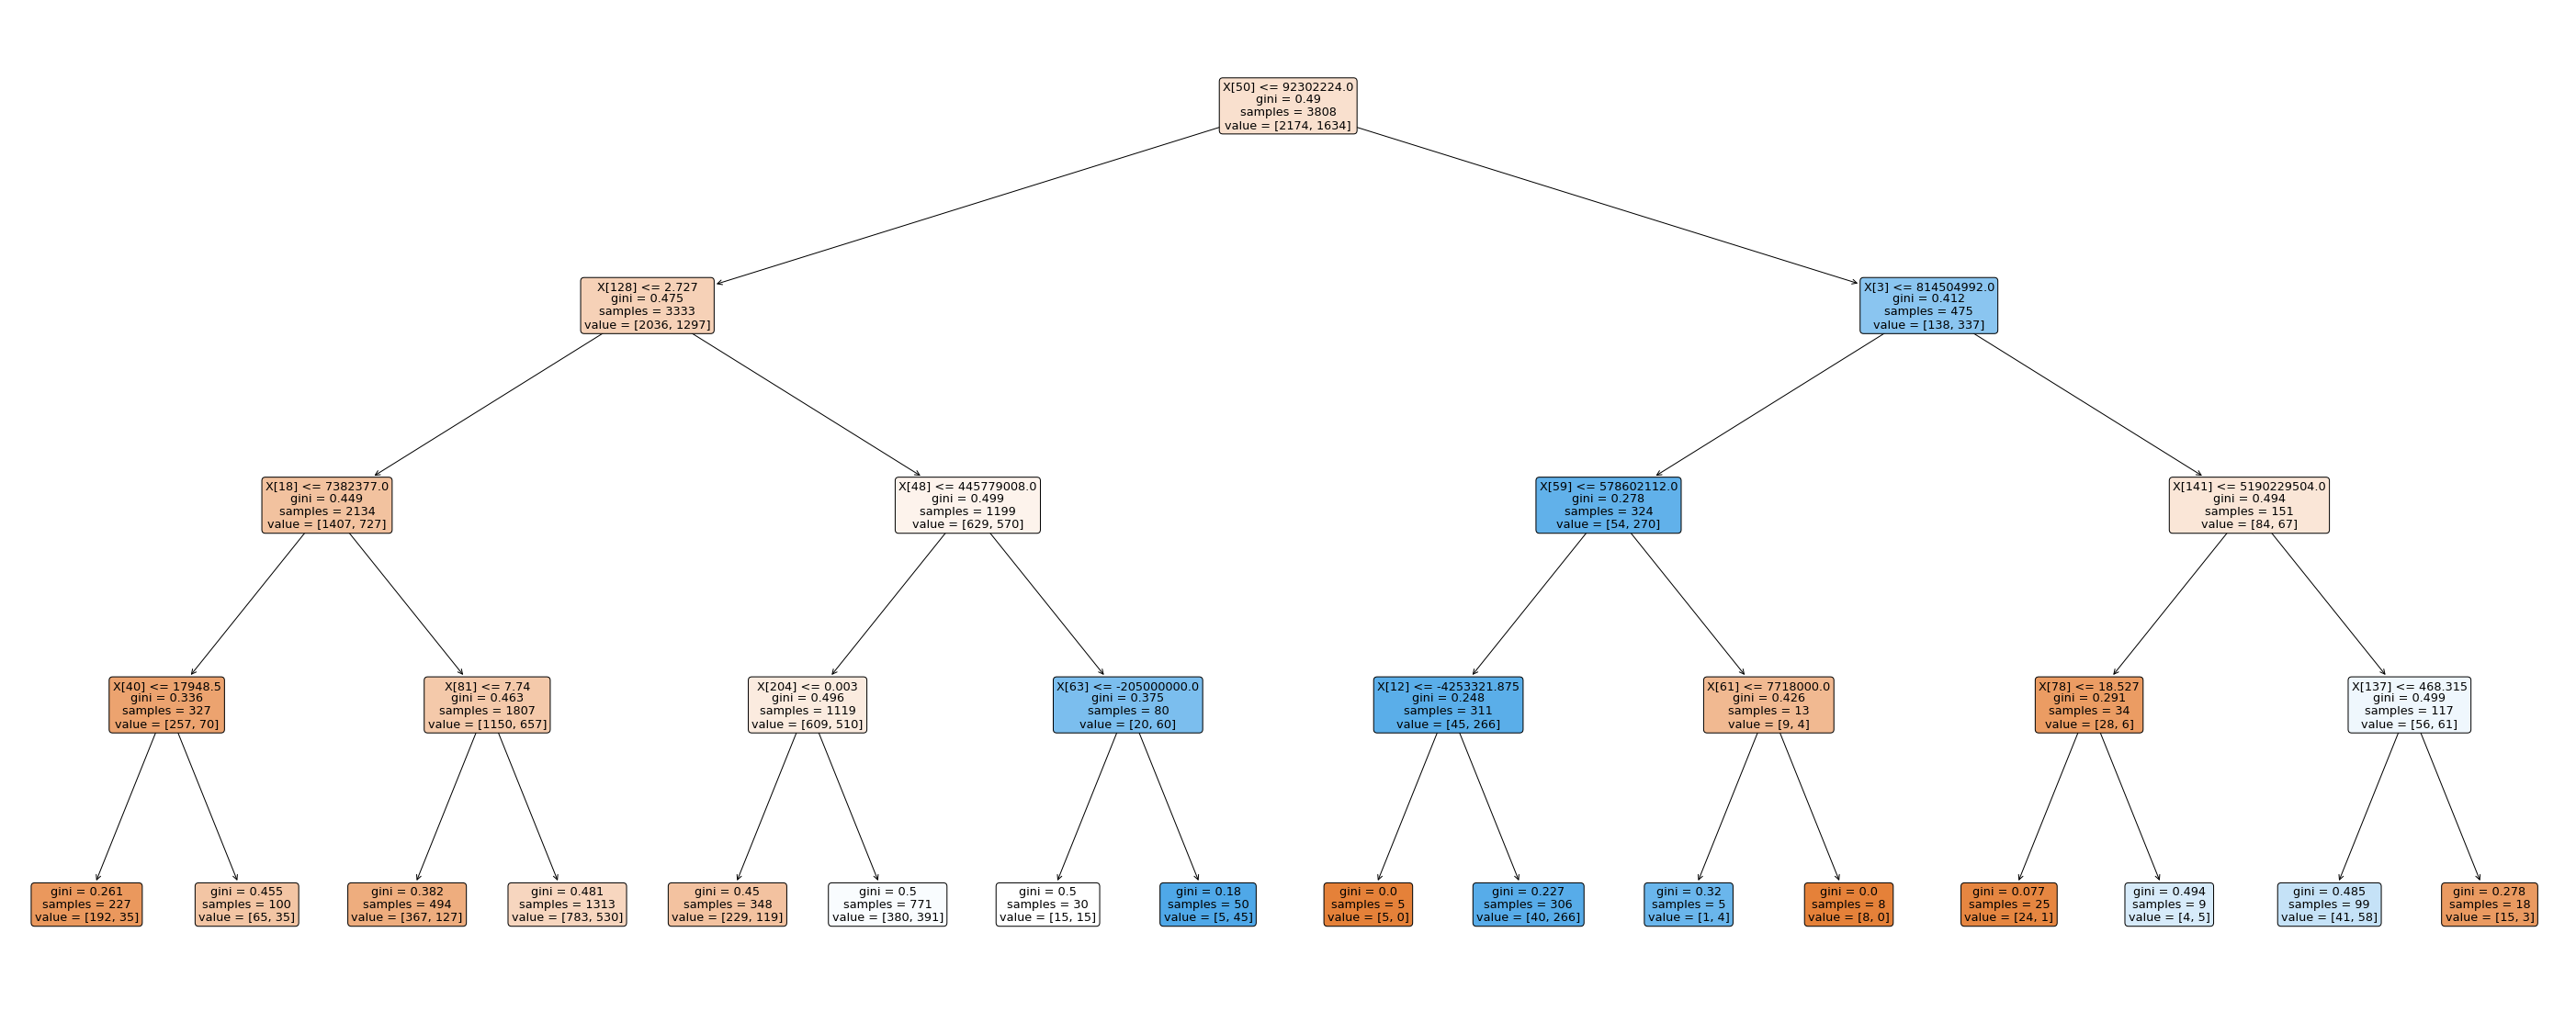

In [16]:
##### naive classification tree in order to see whether one of the variables ommitted is able to explain the dependent variable
Y = df14_imputed['Class']
X = df14_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4)
tree_fit_df14 = tree.fit(X, Y)
plt.figure(figsize = (50, 20))
plot_tree(tree_fit_df14, filled = True, rounded = True)

#tree in text form
tree_text_df14 = export_text(tree_fit_df14, feature_names=list(X))
print(tree_text_df14)

#extract splitting features
tree_features_df14 = tree_fit_df14.tree_.feature
tree_features_df14 = tree_features_df14[tree_features_df14 != -2]
tree_features_df14



##### interpretation of the results from the desicion tree
#for df14:

#function to get the column names of the variables which were used to fit the decision tree
def imp_feat(data, idx): #imp_feat: important features
    res = []
    for el in idx:
        res.append(data.columns[el])
    return(res)

#apply above function to the data set
imp_feat_list_df14 = imp_feat(data = df14_imputed, idx = tree_features_df14)

#gives back a list of features which were used in the classification tree but have "a lot of" NAs
misfits_df14 = []
for el in imp_feat_list_df14:
    if el in high_NA_vars:
        misfits_df14.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df14[misfits_df14].isna().sum()
    #we see that apparently the variable 'priceCashFlowRatio' in the list 'misfits' does NOT have more than the treshold value of NAs for the year 2014 (but for some other year)

In [17]:
#####for 15-18 and df_all

#df15
Y = df15_imputed['Class']
X = df15_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df15 = tree.fit(X, Y)

#extract splitting features
tree_features_df15 = tree_fit_df15.tree_.feature
tree_features_df15 = tree_features_df15[tree_features_df15 != -2]
tree_features_df15

#apply function to get col names
imp_feat_list_df15 = imp_feat(data = df15_imputed, idx = tree_features_df15)

misfits_df15 = []
for el in imp_feat_list_df15:
    if el in high_NA_vars:
        misfits_df15.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 15):')
df15[misfits_df15].isna().sum()


####################################################################################################
#df16
Y = df16_imputed['Class']
X = df16_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df16 = tree.fit(X, Y)

#extract splitting features
tree_features_df16 = tree_fit_df16.tree_.feature
tree_features_df16 = tree_features_df16[tree_features_df16 != -2]
tree_features_df16

#apply function to get col names
imp_feat_list_df16 = imp_feat(data = df16_imputed, idx = tree_features_df16)

misfits_df16 = []
for el in imp_feat_list_df16:
    if el in high_NA_vars:
        misfits_df16.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 16):')
df16[misfits_df16].isna().sum()


####################################################################################################
#df17
Y = df17_imputed['Class']
X = df17_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df17 = tree.fit(X, Y)

#extract splitting features
tree_features_df17 = tree_fit_df17.tree_.feature
tree_features_df17 = tree_features_df17[tree_features_df17 != -2]
tree_features_df17

#apply function to get col names
imp_feat_list_df17 = imp_feat(data = df17_imputed, idx = tree_features_df17)

misfits_df17 = []
for el in imp_feat_list_df17:
    if el in high_NA_vars:
        misfits_df17.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 17):')
df17[misfits_df17].isna().sum()


####################################################################################################
#df18
Y = df18_imputed['Class']
X = df18_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df18 = tree.fit(X, Y)

#extract splitting features
tree_features_df18 = tree_fit_df18.tree_.feature
tree_features_df18 = tree_features_df18[tree_features_df18 != -2]
tree_features_df18

#apply function to get col names
imp_feat_list_df18 = imp_feat(data = df18_imputed, idx = tree_features_df18)

misfits_df18 = []
for el in imp_feat_list_df18:
    if el in high_NA_vars:
        misfits_df18.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 18):')
df18[misfits_df18].isna().sum()



####################################################################################################
#for all the data

Y = df_all_imputed['Class']
X = df_all_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_all = tree.fit(X, Y)
#plt.figure(figsize = (50, 20))
#plot_tree(tree_fit_all, filled = True, rounded = True)

#tree in text form
tree_text_all = export_text(tree_fit_all, feature_names=list(X))
#print(tree_text_all)

#extract splitting features
tree_features_all = tree_fit_all.tree_.feature
tree_features_all = tree_features_all[tree_features_all != -2]
tree_features_all


#apply function to get col names
imp_feat_list_all = imp_feat(data = df_all_imputed, idx = tree_features_all)

misfits = []
for el in imp_feat_list_all:
    if el in high_NA_vars:
        misfits.append(el)


array([ 22, 133,  69, 185,  96,  86,  65,  81, 160,  68, 127, 181, 104,
        30,  90], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 15):


priceCashFlowRatio         1197
shortTermCoverageRatios    1925
dtype: int64

array([  7,  87, 139,  31, 170, 140,  17, 113,  39,  15, 164, 107, 206,
       216,  20], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 16):


ROIC                                1602
5Y Net Income Growth (per Share)    1680
dtype: int64

array([ 86, 110,  44, 182,  12,  20,  23,  80, 151,  85,   3, 163, 204,
       215], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 17):


operatingCycle             4955
enterpriseValueMultiple    1800
dtype: int64

array([174, 195, 143,  61,  38,  16,  68, 208,  81,  65,  16, 210,  24,
         8,  41], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 18):


10Y Shareholders Equity Growth (per Share)    1695
priceCashFlowRatio                            1256
Total non-current assets                      1041
dtype: int64

array([223, 161,  73, 222, 222,  83, 222, 188, 223, 222, 222, 222, 169],
      dtype=int64)

In [18]:
#consolidate all variables which are important for any of the five years
misfits_all = list(set(misfits_df14 + misfits_df15 + misfits_df16 + misfits_df17 + misfits_df18)) #set() in order to remove dublicates
misfits_all

df_temporary = [df14, df15, df16, df17, df18]
for el in df_temporary:
    print(el[misfits_all].isnull().sum(), "\n")

#from this output we conclude that:
    #even if operatingCycle would be able to predict future return, we have way too many NAs
    #also shortTermCoverageRatios and 10y Shareholder Equity Growth has too few values over all years, hence we remove it from the data set
    #we leave in the dataset the following:
        #priceCashFlowRatio
        #5Y Net Income Growth (per Share)
        #enterpriseValueMultiple
        #ROIC
        #Total non-current assets
        
        
        
##### dropping variables with too many NAs

#high_NA_vars #uncomment to see variables that have many NAs

notdrop = ['priceCashFlowRatio', '5Y Net Income Growth (per Share)', 'enterpriseValueMultiple', 'ROIC', 'Total non-current assets']
drop = [x for x in high_NA_vars if x not in notdrop]

df14_imputed.drop(drop, axis = 1, inplace = True)
df15_imputed.drop(drop, axis = 1, inplace = True)
df16_imputed.drop(drop, axis = 1, inplace = True)
df17_imputed.drop(drop, axis = 1, inplace = True)
df18_imputed.drop(drop, axis = 1, inplace = True)
df_all_imputed.drop(drop, axis = 1, inplace = True)

['shortTermCoverageRatios',
 'enterpriseValueMultiple',
 '5Y Net Income Growth (per Share)',
 '10Y Shareholders Equity Growth (per Share)',
 'priceCashFlowRatio',
 'Total non-current assets',
 'ROIC',
 'operatingCycle']

shortTermCoverageRatios                       1956
enterpriseValueMultiple                        944
5Y Net Income Growth (per Share)              1037
10Y Shareholders Equity Growth (per Share)    1585
priceCashFlowRatio                            1053
Total non-current assets                       908
ROIC                                           987
operatingCycle                                3807
dtype: int64 

shortTermCoverageRatios                       1925
enterpriseValueMultiple                       1224
5Y Net Income Growth (per Share)              1214
10Y Shareholders Equity Growth (per Share)    1766
priceCashFlowRatio                            1197
Total non-current assets                      1029
ROIC                                          1125
operatingCycle                                4118
dtype: int64 

shortTermCoverageRatios                       2417
enterpriseValueMultiple                       1751
5Y Net Income Growth (per Share)              1680
1

### further imputing methods
* as the title suggests, here we tried to use different methods
* the first (and second) one is a method that is often used in R
* the third imputation here is based on the (still experimental) iterative imputer from the sklearn package

\
some links that we have found to be useful\
for the MissForest imputer: \
https://github.com/epsilon-machine/missingpy/blob/master/missingpy/missforest.py \
https://towardsdatascience.com/how-to-use-python-and-missforest-algorithm-to-impute-missing-data-ed45eb47cb9a

for the MICE imputer: \
https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.html \
https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22

general:\
https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/

In [19]:
##### MissForest imputer

#drop Stock column for df_all
df_all.drop('Stock', axis=1, inplace=True)
df_all.drop(drop, axis=1, inplace=True)

#make an instance and perform an imputation
imputer2 = MissForest(max_iter = 4, n_estimators = 10, max_depth = 5, n_jobs = -1, random_state = 3)
    #we have (rather dramatically) reduced some input parameters due to the high time complexity of this algorithm (a single iteration with those takes about 10mins on our laptops)

#df 14    
df14_imputed_ver2 = imputer2.fit_transform(df14)
df14_imputed_ver2 = pd.DataFrame(df14_imputed_ver2)
df14_imputed_ver2.columns = list(df14)
df14_imputed_ver2.isnull().sum().sum()


#df 15  
df15_imputed_ver2 = imputer2.fit_transform(df15)
df15_imputed_ver2 = pd.DataFrame(df15_imputed_ver2)
df15_imputed_ver2.columns = list(df15)
df15_imputed_ver2.isnull().sum().sum()


#df 16
df16_imputed_ver2 = imputer2.fit_transform(df16)
df16_imputed_ver2 = pd.DataFrame(df16_imputed_ver2)
df16_imputed_ver2.columns = list(df16)
df16_imputed_ver2.isnull().sum().sum()


#df 17
df17_imputed_ver2 = imputer2.fit_transform(df17)
df17_imputed_ver2 = pd.DataFrame(df17_imputed_ver2)
df17_imputed_ver2.columns = list(df17)
df17_imputed_ver2.isnull().sum().sum()


#df 18
df18_imputed_ver2 = imputer2.fit_transform(df18)
df18_imputed_ver2 = pd.DataFrame(df18_imputed_ver2)
df18_imputed_ver2.columns = list(df18)
df18_imputed_ver2.isnull().sum().sum()


#df_all
df_all_imputed_ver2 = imputer2.fit_transform(df_all)
df_all_imputed_ver2 = pd.DataFrame(df_all_imputed_ver2)
df_all_imputed_ver2.columns = list(df_all)
df_all_imputed_ver2.isnull().sum().sum()


KeyError: "['Stock'] not found in axis"

In [ ]:
##### MICE imputer

#df14_imputed_ver3 = mice.MICEData(df14)
#from fancyimpute import MICE
#imputer3 = MICE(verbose = False)
#df14_imputed_ver3 = imputer3.complete(df14)

    #cannot install module fancyimpute

In [ ]:
##### iterative imputer
iter_imp = IterativeImputer(estimator =  ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=4, verbose=False)
iter_imp.fit(df_all)
df_all_imputed_ver3 = iter_imp.transform(df_all)
df_all_imputed_ver3 = pd.DataFrame(df_all_imputed_ver3, columns=df_all.columns)
    #never actually fully executed this code (terminated after it was still running after 30mins)


## Zero values
when going though the data one thing that came to attention was the many zeroes \
the question is how to handle those zeroes as some make more sense (e.g. 0 R&D Expenses for a gold mining company) while others are more ambiguous (e.g. revenue of 0, very few firms have negative revenues for the year 2014)

In [ ]:
##### inspection of 0-values

def name_gettr_zeroes(data, treshold = 500):
    res = {}
    for el in data[:1]:
        if data[el].isin([0]).sum() > treshold:
            res[el] = data[el].isin([0]).sum()
    return res


df14_zero_vals = list(df14.isin([0]).sum())
df14_zeroes = name_gettr_zeroes(df14)
print(df14_zeroes, '\n' ,'length =', len(df14_zeroes))


df15_zero_vals = df15.isin([0]).sum()
#df15_zero_vals

df16_zero_vals = df16.isin([0]).sum()
#df16_zero_vals

df17_zero_vals = df17.isin([0]).sum()
#df17_zero_vals

df18_zero_vals = df18.isin([0]).sum()
#df18_zero_vals




In [ ]:
#graph showing percentages of zero values

ratio_zeroes = df_all.isin([0]).sum()/len(df_all)
pd.Series.sort_values(ratio_zeroes)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_zeroes)+1), height = ratio_zeroes, width = 1, ec = 'black')
plt.ylabel('percentage zero values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_zeroes)), list(df14.columns), rotation = 90)


In [ ]:
#plotting only the 20 columns with the most zero-values

total_zeroes = df_all.isin([0]).sum().sort_values(ascending=False)
percent_zeroes = (df_all.isin([0]).sum()/df_all.isin([0]).count()*100).sort_values(ascending=False)
df_zeroes = pd.concat([total_zeroes, percent_zeroes], axis = 1, keys = ['total zeroes', 'percent zeroes'])
plt.bar(np.arange(20), df_zeroes['percent zeroes'].iloc[:20].values.tolist())
plt.xticks(np.arange(20), df_zeroes['percent zeroes'].iloc[:20].index.values.tolist(), rotation = 90)
plt.ylabel('percentage zero values (ordered)', fontsize = 12)
plt.rc('ytick', labelsize = 15)
plt.grid(alpha = 0.2, axis = 'y')
plt.show()

#we see that most features with a high percentage of zero values are plausable to be zero (e.g. Dividend/ R&D Expenses)
#we assume that those are not measurement errors/ missing values and hence we decide that those values should not be omitted
#note: however, this says nothing about the importance of these values

## Feature Engineering (Part 2)
### Creation of Macroeconomic factor / Inflation Interaction Term
We can now create the interaction terms with the inflation since we have imputed all the missing values in our data set. First we have to store the inflation data:

In [ ]:
#We first have to load the data, yearly data from 2014 to 2018
Inflation_14 = 0.0162
Inflation_15 = 0.0012
Inflation_16 = 0.0126
Inflation_17 = 0.0214
Inflation_18 = 0.0244

The next step is to think about which interaction terms could have a significant influence on the stock performance. We will create some interaction terms and test them later on in the Feature Selection part.

According to Investopedia (https://www.investopedia.com/articles/investing/052913/inflations-impact-stock-returns.asp) Value stocks perform better in high inflation periods while growth stocks perfrom better during low inflation periods. We can make use of this information and try to add this effect into our model through an interaction term. 

Value Stocks are characterized by a high dividend yield, a low P/B Ratio and a low P/E Ratio (https://www.investopedia.com/terms/v/valuestock.asp). Growth Stocks are characterized by a high P/E Ratio and typically pay no dividend.

It would therefore make sense to test some interaction terms like inflation* dividend yield, inflation * P/E ratio and inflation * P/B ratio.

In [ ]:
#####Inflation Dividend Yield Interaction Terms

Inflation_DY_14 = np.empty(shape = df14_imputed.shape[0])
Inflation_DY_15 = np.empty(shape = df15_imputed.shape[0])
Inflation_DY_16 = np.empty(shape = df16_imputed.shape[0])
Inflation_DY_17 = np.empty(shape = df17_imputed.shape[0])
Inflation_DY_18 = np.empty(shape = df18_imputed.shape[0])

Inflation_DY_14[:] = np.NAN
Inflation_DY_15[:] = np.NAN
Inflation_DY_16[:] = np.NAN
Inflation_DY_17[:] = np.NAN
Inflation_DY_18[:] = np.NAN

#df14
for idx, dy in enumerate(df14_imputed["Dividend Yield"]):
    Inflation_DY_14[idx] = (Inflation_14 * dy)
    
#df15
for idx, dy in enumerate(df15_imputed["Dividend Yield"]):
    Inflation_DY_15[idx] = (Inflation_15 * dy)
    
#df16
for idx, dy in enumerate(df16_imputed["Dividend Yield"]):
    Inflation_DY_16[idx] = (Inflation_16 * dy)
    
#df17
for idx, dy in enumerate(df17_imputed["Dividend Yield"]):
    Inflation_DY_17[idx] = (Inflation_17 * dy)
    
#df18
for idx, dy in enumerate(df18_imputed["Dividend Yield"]):
    Inflation_DY_18[idx] = (Inflation_18 * dy)
    
Inflation_DY_14 = pd.Series(Inflation_DY_14)
Inflation_DY_15 = pd.Series(Inflation_DY_15)
Inflation_DY_16 = pd.Series(Inflation_DY_16)
Inflation_DY_17 = pd.Series(Inflation_DY_17)
Inflation_DY_18 = pd.Series(Inflation_DY_18)


Inflation_DY = pd.concat([Inflation_DY_14, Inflation_DY_15, Inflation_DY_16, Inflation_DY_17, Inflation_DY_18], ignore_index = True)

#Add it to df_all_imputed
df_all_imputed["Inflation_DY"] = Inflation_DY

print(df_all_imputed.columns)

In [ ]:
###Inflation Price-Earnings Ratio Interaction Terms

Inflation_PER_14 = np.empty(shape = df14_imputed.shape[0])
Inflation_PER_15 = np.empty(shape = df15_imputed.shape[0])
Inflation_PER_16 = np.empty(shape = df16_imputed.shape[0])
Inflation_PER_17 = np.empty(shape = df17_imputed.shape[0])
Inflation_PER_18 = np.empty(shape = df18_imputed.shape[0])

Inflation_PER_14[:] = np.NAN
Inflation_PER_15[:] = np.NAN
Inflation_PER_16[:] = np.NAN
Inflation_PER_17[:] = np.NAN
Inflation_PER_18[:] = np.NAN

#df14
for idx, PER in enumerate(df14_imputed["priceEarningsRatio"]):
    Inflation_PER_14[idx] = (Inflation_14 * PER)
    
#df15
for idx, PER in enumerate(df15_imputed["priceEarningsRatio"]):
    Inflation_PER_15[idx] = (Inflation_15 * PER)
    
#df16
for idx, PER in enumerate(df16_imputed["priceEarningsRatio"]):
    Inflation_PER_16[idx] = (Inflation_16 * PER)
    
#df17
for idx, PER in enumerate(df17_imputed["priceEarningsRatio"]):
    Inflation_PER_17[idx] = (Inflation_17 * PER)
    
#df18
for idx, PER in enumerate(df18_imputed["priceEarningsRatio"]):
    Inflation_PER_18[idx] = (Inflation_18 * PER)
    
Inflation_PER_14 = pd.Series(Inflation_PER_14)
Inflation_PER_15 = pd.Series(Inflation_PER_15)
Inflation_PER_16 = pd.Series(Inflation_PER_16)
Inflation_PER_17 = pd.Series(Inflation_PER_17)
Inflation_PER_18 = pd.Series(Inflation_PER_18)


Inflation_PER = pd.concat([Inflation_PER_14, Inflation_PER_15, Inflation_PER_16, Inflation_PER_17, Inflation_PER_18], ignore_index = True)

#Add it to df_all_imputed
df_all_imputed["Inflation_PER"] = Inflation_PER

print(df_all_imputed.columns

In [ ]:
###Inflation Price-Book Ratio Interaction Terms

Inflation_PBR_14 = np.empty(shape = df14_imputed.shape[0])
Inflation_PBR_15 = np.empty(shape = df15_imputed.shape[0])
Inflation_PBR_16 = np.empty(shape = df16_imputed.shape[0])
Inflation_PBR_17 = np.empty(shape = df17_imputed.shape[0])
Inflation_PBR_18 = np.empty(shape = df18_imputed.shape[0])

Inflation_PBR_14[:] = np.NAN
Inflation_PBR_15[:] = np.NAN
Inflation_PBR_16[:] = np.NAN
Inflation_PBR_17[:] = np.NAN
Inflation_PBR_18[:] = np.NAN

#df14
for idx, PBR in enumerate(df14_imputed["priceToBookRatio"]):
    Inflation_PBR_14[idx] = (Inflation_14 * PBR)
    
#df15
for idx, PBR in enumerate(df15_imputed["priceToBookRatio"]):
    Inflation_PBR_15[idx] = (Inflation_15 * PBR)
    
#df16
for idx, PBR in enumerate(df16_imputed["priceToBookRatio"]):
    Inflation_PBR_16[idx] = (Inflation_16 * PBR)
    
#df17
for idx, PBR in enumerate(df17_imputed["priceToBookRatio"]):
    Inflation_PBR_17[idx] = (Inflation_17 * PBR)
    
#df18
for idx, PBR in enumerate(df18_imputed["priceToBookRatio"]):
    Inflation_PBR_18[idx] = (Inflation_18 * PBR)
    
Inflation_PBR_14 = pd.Series(Inflation_PBR_14)
Inflation_PBR_15 = pd.Series(Inflation_PBR_15)
Inflation_PBR_16 = pd.Series(Inflation_PBR_16)
Inflation_PBR_17 = pd.Series(Inflation_PBR_17)
Inflation_PBR_18 = pd.Series(Inflation_PBR_18)


Inflation_PBR = pd.concat([Inflation_PBR_14, Inflation_PBR_15, Inflation_PBR_16, Inflation_PBR_17, Inflation_PBR_18], ignore_index = True)

#Add it to df_all_imputed
df_all_imputed["Inflation_PBR"] = Inflation_PBR

### Outliers
one more thing to consider before jumping into the process of fitting models are outliers \
the first and probably most prominent method is to cut off at some multiple of the stdv which however, requires the variables to follow a normal distribution (which is rather unlikely if I had to take an a priori guess)
another possibility is to work with the IQR method which is not in need of such a strong assumption

In [ ]:
##### checking for multivariate normality (Heinze-Zirkler test)
    #note: if we only had a handful of features we could use common methods like the Shapiro-Wilk test or even simple QQ-plots
print(pg.multivariate_normality(df14_imputed))


#Thus we see that the data is not multivariate normal, according to the Heinze-Zirkler test
#i.e., we can not apply functions which are meant for Gaussian data



In [ ]:
#### IQR (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

#function that returns the IQR for each column of our data set
def IQR_gettr(data):
    IQR = {}
    for el in data.columns:
        q25 = np.percentile(np.array(data[el]), 25)
        q75 = np.percentile(np.array(data[el]), 75)
        IQR[el] = round(q75 - q25, 4)
    return IQR

#function that returns which variables have an IQR equal to 0, input must be a dictionary
def IQR_zeroes(dictionary):
    res = {}
    for key, val in dictionary.items():
        if not val:
            res[key] = dictionary[key]
    return res



df14_IQR = IQR_gettr(df14_imputed) #dictionary
df14_IQR_zeroes = IQR_zeroes(df14_IQR) #dictionary
        
df15_IQR = IQR_gettr(df15_imputed)
df15_IQR_zeroes = IQR_zeroes(df15_IQR)

df16_IQR = IQR_gettr(df16_imputed)
df16_IQR_zeroes = IQR_zeroes(df16_IQR)

df17_IQR = IQR_gettr(df17_imputed)
df17_IQR_zeroes = IQR_zeroes(df17_IQR)

df18_IQR = IQR_gettr(df18_imputed)
df18_IQR_zeroes = IQR_zeroes(df18_IQR)


In [ ]:
#input = imputed dataframe
#desired output = dataframe which took care of outliers, i.e., it restricts outliers to the IQR distance times 1.5

def IQR_outlier_manager(data):
    upper_lower_bound = {}
    
    for el in data.columns:
        q25 = np.percentile(np.array(data[el]), 25)
        q75 = np.percentile(np.array(data[el]), 75)
        IQR = (q75 - q25)
        
        upper_lower_bound[el] = [q75 + IQR * 1.5, q25 - IQR * 1.5]
        
    
    #until here we created a dictionary with the column name as the key and the
    #Interquantile distance (upper and lower borders, times a threshold (1.5)) as value
    
    outlier_count_lower = 0
    outlier_count_upper = 0
    
    res = {}
    
    
    for el in data.columns:
        upper = upper_lower_bound[el][0]
        lower = upper_lower_bound[el][1]
        
        res[el] = []
        #here we extract the upper and lower bound per column of the dataframe
        
        for e in data[el]:
            if e > upper:
                res[el].append(upper)
                outlier_count_upper += 1
            elif e < lower:
                res[el].append(lower)
                outlier_count_lower += 1
            else:
                res[el].append(e)
        #then we check whether the entries of the columns are larger or smaller than our borders, if so
        #we reset them to lie on the border, furthermore we count the amount of outliers overall
    
    res = pd.DataFrame.from_dict(res)
    #print(f"Amount of outliers below: {outlier_count_lower}\nAmount of outliers above: {outlier_count_upper}")
    return res

#Finally we return our new modified dataframe and the amount of outliers we counted (upper and lower separated)
    

In [ ]:
df14_imputed_outliercorrected = IQR_outlier_manager(df14_imputed)
df15_imputed_outliercorrected = IQR_outlier_manager(df15_imputed)
df16_imputed_outliercorrected = IQR_outlier_manager(df16_imputed)
df17_imputed_outliercorrected = IQR_outlier_manager(df17_imputed)
df18_imputed_outliercorrected = IQR_outlier_manager(df18_imputed)


# df14_imputed_outliercorrected['Revenue'][3079]             #after
# df14_imputed['Revenue'][3079]                               #before

# np.percentile(df14_imputed['Revenue'], 75) + (np.percentile(df14_imputed['Revenue'], 75) - np.percentile(df14_imputed['Revenue'], 25)) * 1.5
# np.percentile(df14_imputed['Revenue'], 25) - (np.percentile(df14_imputed['Revenue'], 75) - np.percentile(df14_imputed['Revenue'], 25)) * 1.5



In [ ]:
#convert df_all_imputed to a dataframe
df_all_imputed = pd.DataFrame(df_all_imputed)

#we create a oultier-corrected dataframe over all five years (IQR Method)
df_all_imputed_outliercorrected = IQR_outlier_manager(df_all_imputed)
df_all_imputed_outliercorrected

In [ ]:
#another method for outlier handling
#idea: reset top 5% and bottom 5% to the 5. and 95. percentile (90%-Winsorization)
#conceptionally the same approach with a less radical cut-off

df14_top5_outliers = df14_imputed.quantile(.95)
df14_bottom5_outliers = df14_imputed.quantile(.05)

df14_imputed_outliercorrected_ver2 = df14_imputed.mask(df14_imputed > df14_top5_outliers, df14_top5_outliers, axis=1)
df14_imputed_outliercorrected_ver2 = df14_imputed.mask(df14_imputed < df14_bottom5_outliers, df14_bottom5_outliers, axis=1)

# df14_imputed_outliercorrected_ver2.describe()
# df14_imputed_outliercorrected.describe()

#for df15
df15_top5_outliers = df15_imputed.quantile(.95)
df15_bottom5_outliers = df15_imputed.quantile(.05)

df15_imputed_outliercorrected_ver2 = df15_imputed.mask(df15_imputed > df15_top5_outliers, df15_top5_outliers, axis=1)
df15_imputed_outliercorrected_ver2 = df15_imputed.mask(df15_imputed < df15_bottom5_outliers, df15_bottom5_outliers, axis=1)


#for df16
df16_top5_outliers = df16_imputed.quantile(.95)
df16_bottom5_outliers = df16_imputed.quantile(.05)

df16_imputed_outliercorrected_ver2 = df16_imputed.mask(df16_imputed > df16_top5_outliers, df16_top5_outliers, axis=1)
df16_imputed_outliercorrected_ver2 = df16_imputed.mask(df16_imputed < df16_bottom5_outliers, df16_bottom5_outliers, axis=1)


#for df17
df17_top5_outliers = df17_imputed.quantile(.95)
df17_bottom5_outliers = df17_imputed.quantile(.05)

df17_imputed_outliercorrected_ver2 = df17_imputed.mask(df17_imputed > df17_top5_outliers, df17_top5_outliers, axis=1)
df17_imputed_outliercorrected_ver2 = df17_imputed.mask(df17_imputed < df17_bottom5_outliers, df17_bottom5_outliers, axis=1)


#for df18
df18_top5_outliers = df18_imputed.quantile(.95)
df18_bottom5_outliers = df18_imputed.quantile(.05)

df18_imputed_outliercorrected_ver2 = df18_imputed.mask(df18_imputed > df18_top5_outliers, df18_top5_outliers, axis=1)
df18_imputed_outliercorrected_ver2 = df18_imputed.mask(df18_imputed < df18_bottom5_outliers, df18_bottom5_outliers, axis=1)


## Feature Selection

TODO: bcs depends on how df looks like

In [ ]:
# TODO

df = df_all_imputed_outliercorrected

# TODO: check if these are all that need to be dropped and if now only: stock, features, response
df = df.drop(['PRICE_VAR'], axis=1)
df = df.drop(['Class'], axis=1)
df = df.drop(['year'], axis=1)

# Move recommendation column to the end
rec = df['recommendation'].values
df = df.drop(['recommendation'], axis=1)
df['recommendation'] = rec

# TODO: is X correct?
X = df.iloc[:, :-1].values     # or [:, 1:-1] if stock not in df?!    -1 correct?        
y = df['recommendation'].values

# TODO: or [1:-1]]
feat_labels = df.columns[:-1]   

### Class Imbalance (TODO)

TODO: Test whether models are better with or without handling class imbalance

In [ ]:
##### Balance of recommendation classes

# nr of rows with recommendation -1
n_sell = len(df[df['recommendation'] == -1])

# nr of rows with recommendation 0 
n_hold = len(df[df['recommendation'] == 0])

# nr of rows with recommendation 1
n_buy = len(df[df['recommendation'] == 1])

sum_n = n_sell + n_hold + n_buy

print('BEFORE UPSAMPLING:')
print('Number of titels to sell: {}, {:.2%}'.format(n_sell, n_sell/sum_n))
print('Number of titels to hold: {}, {:.2%}'.format(n_hold, n_hold/sum_n))
print('Number of titels to buy: {}, {:.2%}\n'.format(n_buy, n_buy/sum_n))

# plot amounts
plt.figure(figsize=(5, 5))
plt.bar(range(3), [n_sell, n_hold, n_buy], width=0.5, align ='center', color='lightseagreen')
plt.xticks(range(3), ['# sell', '# hold', '# buy'])
plt.ylabel('Amount')


print('Shape of X before: {}'.format(X.shape))

# TODO: dealing with class imbalance necessary??

'''
# Upsampling of class "hold" (# = 8000)
X_upsampled, y_upsampled = resample(X[y==0], y[y==0], replace=True, n_samples=8000, random_state=0)

# combinde datasets
X_bal = np.vstack((X, X_upsampled))
y_bal = np.hstack((y, y_upsampled))

print('Shape of X_bal after: {}\n'.format(X_bal.shape))

n_hold_new = np.sum(y_bal == 0)
sum_new = n_sell+n_hold_new+n_buy

print('AFTER UPSAMPLING:')
print('Number of titels to sell: {}, {:.2%}'.format(n_sell, n_sell/sum_new))
print('Number of titels to hold: {}, {:.2%}'.format(n_hold_new, n_hold_new/sum_new))
print('Number of titels to buy: {}, {:.2%}'.format(n_buy, n_buy/sum_new))

df.shape
'''

### Feature Selection

In [ ]:
##### Train/Test Split
# TODO: use X_bal, y_bal for feature selection?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)

**Removing Constant Features**

https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/

In [ ]:
## Removing Constant Features using Variance Threshold
from sklearn.feature_selection import VarianceThreshold

# get constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
print('Out of {} features {} are constant \n'.format(len(feat_labels), len(feat_labels)-len(feat_labels[constant_filter.get_support()])))

constant_features = [f for f in feat_labels if f not in feat_labels[constant_filter.get_support()]]

print('Constant features: \n' + 30*'-')
for feature in constant_features: print(feature)

# remove constant features   
feat_labels = [f for f in feat_labels if f not in constant_features]
X_train = constant_filter.transform(X_train)
X_test = constant_filter.transform(X_test)

print('\nNew shape:')
print(X_train.shape, X_test.shape)

**Removing highly correlated features**

https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/

Correlation between the output observations and the input features is very important and such features should be retained. However, if two or more than two features are mutually correlated, they convey redundant information to the model and hence only one of the correlated features should be retained to reduce the number of features.

ONLY USE NUMERICAL FEATURES, NOT DUMMIES!

In [ ]:
## remove highly correlated features

# TODO: All columns :-??? are numerical

# check if categorical var:
# df.shape[0] * df.shape[1] - df.applymap(np.isreal).sum().sum()
# if result = 0 no categorical data

# TODO: df without response columns and without dummies
df_num = df.iloc[:,:-???]

correlated_features = set()   # empty set that will contain names of all correlated features
correlation_matrix = df_num.corr()   # corr matrix

# loop through all col in corr matrix and add col with corr value > 0.8 to set
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('{} of {} features have a correlation > 0.8  ({:.2%})'.format(len(correlated_features), len(feat_labels), len(correlated_features)/len(feat_labels)))

print(correlated_features)

# remove correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)


In [ ]:
# TODO: X correct?
X = df.iloc[:, :-1].values
y = df['recommendation'].values

# TODO: 1:-1?
feat_labels = df.columns[1:-1]  

##### Train/Test Split
# TODO: use X_bal, y_bal?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)

### Random Forest Classifier for Feature Selection

train a random forest model on the balanced
default data set!!

Cross-entropy is minimal if all samples at a node belong to
the same class and maximal if we have a homogeneous distribution among the classes. Therefore,
cross-entropy can be understood as a criterion that attempts to maximize the mutual information
in the tree. The Gini-index on the other hand works towards minimizing the probability of misclassification. Similar to entropy it is maximal if classes are evenly distributed and minimal if the vast
majority of samples belong to the same class.

**Gini**: 

In practice both Gini index as well as cross-entropy usually produce similar results and thus it is not
advisable to spend much time on evaluating trees using different impurity criteria (Raschka (2015)). [p.117]

--> since gini faster we used this (default = gini)

classes must be balanced to get good result, faster https://quantdare.com/decision-trees-gini-vs-entropy/

**Cross-Entropy:** criterion thtat attempts to maximize the mutual information in the tree

----------------------------

**n_estimators:**
This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable. https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

In [ ]:
##### Feature Selection with Random Forest Classifier

# TODO: Use kernel above if you want to deal with class imbalance!!!

model1 = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)   #TODO: n_estimators, random state?
model1.fit(X_train, y_train)
importances1 = model1.feature_importances_

'''
## Top n features
# sort byrelative importance 
indices1 = np.argsort(importances1)[::-1]
n = 50 
for i in range(n):
    print('{0:2d}) {1:50s} {2:6.4f}'.format(i+1, feat_labels[indices1[i]], importances1[indices1[i]]))
print('\n')
'''

https://www.kaggle.com/dkim1992/feature-selection-ranking

Instead of selecting the top n features you define a threshold, which selects those features whose
combined importance is greater or equal to said threshold (e.g. mean, median etc.).

In [ ]:
## SelectFromModel
# Importance > median
feature_selection1 = SelectFromModel(model1, threshold='median', prefit=True)  # prefit=True because fitted above
selected_feat1 = feat_labels[(feature_selection1.get_support())]
print('selected_feat1')

for i in range(len(selected_feat1)):
    print('{0:2d}) {1:50s} {2:6.4f}'.format(i+1, feat_labels[indices1[i]], importances1[indices1[i]]))

Remark: After removing highly correlated features and no variance fatures the importance values increased!

In [ ]:
# plot result
# n = 50 hier TODO
feat_imp = np.sort(importances1)[::-1]
sum_feat_imp = np.cumsum(feat_imp)[:n]

plt.figure(figsize=(12, 8))
plt.bar(range(n), importances1[indices1[:n]], align ='center')
plt.xticks(range(n), feat_labels[indices1[:n]], rotation =90)
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Relative Feature Importance')
plt.step(range(n), sum_feat_imp , where ='mid', label = 'Cumulative importance')
plt.tight_layout();

In [ ]:
##### Correlation matrix
s_f1 = []
for i in range(len(selected_feat1)):
    s_f1.append(feat_labels[indices1[i]])
    
fs1_df = df[[f for f in s_f1]]

fig1, ax1 = plt.subplots(figsize=(20,15)) 
sns.heatmap(fs1_df.corr(), annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax1)
plt.show()

### Model 2 for Feature Selection: njä

-> here not integrated

### PCA for Features Selection:

njä -> here not integrated

In [ ]:
'''
##### Feature Selection with PCA

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

### tbd
# TODO: apply on balanced and scaled set!
#X_train_bal

# if not yet scaled: Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)    


###### visualize cumulative explained variance ratio as a function of the number of components

# run PCA for all possible PCs
pca = PCA().fit(X_scaled)

# Define max no. of PC
# q = X_train.shape[1]
q = 100

# Get cumsumof the PC 1-c
print('First {} PC explain {:.2%} of the variance'.format(str(q), np.sum(pca.explained_variance_ratio_[:q])))
      
expl_var = pca.explained_variance_ratio_[:q]
sum_expl_var = np.cumsum(expl_var)[:q]

# Plot PC Importance (cumul. and individual)
plt.figure(figsize=(12, 6))
plt.bar(range(1, q+1), expl_var, align='center')
plt.xticks(range(1, q+1, 5))
plt.xlim([0, q+1])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.step(range(1, 1+q), sum_expl_var, where='mid')
plt.tight_layout();

First 18 PC explain variance, rest doesn't.
Only PC1 is significant

In [ ]:
'''
# importance of each feature is reflected by the magnitude of the corresponding 
# values in the eigenvectors (higher magnitude - higher importance)

###### amout of explained variance for each PC

# [%PC1, %PC2, ...]
exp_pc_q = pca.explained_variance_ratio_[:q]
print('Explained Variance of {} first PCs'.format(q))
print(exp_pc_q)
print('\n')

###### Most important features

# 1. pca.components_ has shape [n_components, n_features] 
#    PC1 ist first row -> highest features in this row are the most important
# 2. look at absolute values of the Eigenvectors' components corresponding to the k largest Eigenvalues
#    In sklearn the components are sorted by explained_variance_. The larger they are these absolute values, 
#    the more a specific feature contributes to that principal component.
abs_val_ev = abs(pca.components_)[:q,:]
print(abs_val_ev)
print('\n')


###### Get names of most important features

np.random.seed(0)
# 10 samples (pc) with 5 features (10x5), feature values: [0,1)
train_features = np.random.rand(10,X.shape[1])

# nr of PC we want to use because of cum. % of variance they explain
num_pc_chosen = 10   # get from plot

model = PCA(n_components=num_pc_chosen).fit(X_train)
# XX X_pc = model.transform(X_train)

# number ofcomponents
# XX n_pcs = model.components_.shape[0]   # = num_pc_chosen


######################################################################################################
# INSTEAD OF 1 HIGHEST, LOOK AT 10 HIGHEST in line 80
# OR 
# WEIGHT EACH FEATURE BY THE VARIANCE EXPLAINED IN EACH PC -> RANKING OF FEATURES BY SUM OVER ALL PC's
# to solve ***
#####################################################################################################
PC_CHOSEN = q
exp_pc_q # sorted

overall_f_importance = []  # overall importance of features over all 10 pc
pc_idx = 0
v = 0 
for i in range(X.shape[1]):
    for pc in abs_val_ev:
        v += pc[i]*exp_pc_q[pc_idx]
        pc_idx += 1
    overall_f_importance.append(v)
    v = 0
    pc_idx = 0
    


# get index of the most important feature on each component
most_important_idx = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]


# get feature names
feature_names = list(df.columns[:-5])
sorted_overall_f_importance = np.sort(overall_f_importance)[::-1]
sorted_indices = np.argsort(overall_f_importance)[::-1]
sorted_important_features = [feature_names[i] for i in sorted_indices]


dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
print(dic)


print('50 most important features (importance of each feature in first 10 PC, \
weighted with PC variance coverage percentage)')
for i in range(q):
    print('{0:2d}) {1:50s} {2:6.9f}'.format(i+1, sorted_important_features[i], sorted_overall_f_importance[i]))


# build the dataframe
df_pc = pd.DataFrame(dic.items())


#### ***like this only most important feature per PC
'''

In [ ]:
'''
##### Correlation matrix
s_f3 = df[[f for f in sorted_important_features[:q]]]

fig3, ax3 = plt.subplots(figsize=(20,15)) 
sns.heatmap(s_f3.corr(), annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax3)
plt.show()
'''

## Classifiers

### Support Vector Machines (not finito)

In [ ]:
### SVM Classifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

# unbalanced ds on fs
'''
pipe_svm = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('svm', SVC(random_state=0))])
'''
pipe_svm = Pipeline([('svm', SVC(random_state=0, class_weight='balanced'))])

param_grid_svm = [ {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
                   {'svm__C': [1, 10, 100, 1000], 'svm__gamma': [0.001, 0.0001], 'svm__kernel': ['rbf']}]

'''
param_grid_svm = {'svm__kernel': ['linear','rbf','poly','sigmoid'],
                  'svm__C': [1, 10, 100, 1000],
                  'svm__degree': [1, 2, 3, 5, 7],
                  'svm__gamma': [0.01, 0.001, 0.0001],
                  'svm__coef0': [0, 1, 2],
                  'svm__class_weight': ['balanced', None]}
'''

# TODO: on balanced or unbalanced ds?
grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train, y_train)

print('Best CV accuracy: {: .2 f}'.format(grid_svm.best_score_))
print('Test score: {: .2 f}'.format(grid_svm.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_svm.best_params_))

###############################################################################
'''
svm_???.fit(X_train_std, y_train)
# Print results
print("Observed probability of non-default: {: .2 f}".format(np.count_nonzero(y_train ==0) / len( y_train )))
print (" Train score : {: .2 f}"
. format ( svm_linear . score ( X_train_std , y_train )))
print (" Test score : {: .2 f}"
. format ( svm_linear . score ( X_test_std , y_test )))
'''
###############################################################################
'''
## Predict Recommendation
y_pred_svm = svm_???.predict(X_test_std)
y_pred_bal_svm = svm_???.predict(X_test_bal_std)  # try out on balanced ds

## Confusion Matrix
# not balanced
print(metrics.confusion_matrix(y_test, y_pred))
# balanced
print(metrics.confusion_matrix(y_test_bal, y_pred_bal))

## Test scores 
# not balanced
print('Scores with balanced set:')
print(metrics.classification_report(y_test, y_pred))
print('\n')
print("Test score: {: .2 f}".format(svm_???.score(X_test_std, y_test)))
# balanced
print('Scores with balanced set:')
print(metrics.classification_report(y_test_bal, y_pred_bal))
print('\n')
print("Test score: {: .2 f}".format(svm_???_bal.score(X_test_bal_std, y_test_bal)))
'''

## collection of thougts
### Imputing

possible ways of imputing:
* dropna() -> not very elaborate, dropping all NAs would result in a major data waste
* fillna() -> very simplistic method, probably not appropriate
* imputing with mean values -> [...] [T]he correlation structure of a dataset may not be captured if the decision is to plug missing values with zeros or with mean value over the samples. (Imputation of Missing Values in Economic and Financial Time Series Data Using Five Principal Component Analysis (PCA) Approaches, 2019, s. 52)
* imputing with median values
* imputing with most frequent value
* imputing with mean/median/most frequent value of each of the sectors (assuming macro-trends and macro-factors within each sector)
* KNN imputation
* iterative imputer (scikit-learn)


possible papers:
* A review on missing value estimation using imputation algorithm, Journal of Physics ConferenceSeries
* Gautrain, C., & Ravi, V. (2015). Data imputation via evolutionary computation,clustering and a neural network. Neurocomputing, 156:134-142
* Ping, X. O., Lai F., Tseng Y.J, Liang J. D., Huang G. T., Yang, P.M. (2014).Evaluation of imputation methods for missing data and their eﬀect on thereliability of predictive models. International Conference on Bioinformatics,Biocomputational Systems and Biotechnologies, 6, 8-14.
* Schmitt, P; Mandel, J; & Guedj, M. (2015). A comparison of six methods formissing data imputation. Journal of Biometrics & Biostatistics, 6(224), 1-6.
* Imputation of Missing Values in Economic and Financial Time Series Data Using Five Principal Component Analysis (PCA) Approaches, August 2019, Central Bank of Ntigeria Journal of Applied Statistics, DOI: 10.33429/Cjas.10119.3/6
* IMPUTATION OF MISSING VALUES IN THE FUNDAMENTAL DATA: UNLEASHING MICE FRAMEWORK

other help/links:
* https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/

approach:
* multiple imputation (i.e. apply several imputation methods and analyse how the different methods affects performance of the algorithm)

### Zero values
* treat as NAs or simply as "zeroes"?
* maybe mixed? depending on 

### Topics to consider
* imputing
    * (e.g. KNN, https://www.kaggle.com/priyankasachdeva20/catboost-model-to-classify-buy-or-sell-stocks/comments line 11)
    * https://scikit-learn.org/stable/modules/impute.html
    * perhaps different methods for different variables
* 0s in df
* outliers
    * Z score - not the right approach, since it assumes normality which is violated
    * IQR
    * 90% Winsorisation - top and bottom 5% handled as outliers



* selection of relevant ratios/fundamental data
    * remove variables which are heavily correlated to each other (see line 7 in https://www.kaggle.com/mikevasi/risk-aversion-in-the-stock-market)
* feature engineering 
    * https://www.nber.org/system/files/working_papers/w25398/w25398.pdf (Dacheng, Empirical Asset Pricing via ML)
    * momentum?
    * categorical variable for market cap
* class imbalance
    * use the stratify option available within sklearn.model_selection.train_test_split
* analysis